# Adding Primary Location to individuals

After assigning an activity chain to each individual, we then need to map these activities to geographic locations. We start with primary locations (work, school) and fill in the gaps later with discretionary locations. This notebook will focus on the primary locations.

We follow the steps outlined in this [github issue](https://github.com/Urban-Analytics-Technology-Platform/acbm/issues/12)

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Explore trip from and trip to for all individual activities

In [2]:
# read parquet file
activity_chains = pd.read_parquet('../data/interim/matching/spc_with_nts_trips.parquet')
activity_chains.head(10)

,id,household,location,pid_hs,msoa,oa,members,sic1d2007,sic2d2007,pwkstat,...,TripStart,TripEnd,TripDisIncSW,TripDisExSW,TripTotalTime,TripTravTime,TripOrigGOR_B02ID,TripDestGOR_B02ID,W5,W5xHH
0,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,1005.0,1020.0,5.0,5.0,15.0,15.0,9.0,9.0,0.721904,1.000000
1,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,1030.0,1050.0,9.0,9.0,20.0,20.0,9.0,8.0,0.721904,1.000000
2,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,1215.0,1235.0,9.0,9.0,20.0,20.0,8.0,9.0,0.721904,1.000000
3,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,1240.0,1255.0,5.0,5.0,15.0,15.0,9.0,9.0,0.721904,1.000000
4,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,720.0,730.0,2.0,2.0,10.0,10.0,9.0,9.0,0.869370,1.204273
5,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,735.0,745.0,3.0,3.0,10.0,10.0,9.0,9.0,0.721904,1.000000
6,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,825.0,830.0,1.0,1.0,5.0,5.0,9.0,9.0,0.721904,1.000000
7,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,900.0,905.0,1.0,1.0,5.0,5.0,9.0,9.0,0.721904,1.000000
8,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,1065.0,1070.0,1.0,1.0,5.0,5.0,9.0,9.0,0.721904,1.000000
9,0,0,"{'x': -1.7892179489135742, 'y': 53.91915130615...",2905399,E02002183,E00053954,[0],J,58.0,6,...,690.0,700.0,3.0,3.0,10.0,10.0,9.0,9.0,0.812293,1.125208


### Data preparation: Mapping trip purposes

Rename columns and map actual modes and trip purposes to the trip table. 

Code taken from: https://github.com/arup-group/pam/blob/main/examples/07_travel_survey_to_matsim.ipynb

In [3]:
activity_chains = activity_chains.rename(
    columns={  # rename data
        "JourSeq": "seq",
        "TripOrigGOR_B02ID": "ozone",
        "TripDestGOR_B02ID": "dzone",
        "TripPurpFrom_B01ID": "oact",
        "TripPurpTo_B01ID": "dact",
        "MainMode_B04ID": "mode",
        "TripStart": "tst",
        "TripEnd": "tet",
    }
)

Check the NTS glossary [here](https://www.gov.uk/government/statistics/national-travel-survey-2022-technical-report/national-travel-survey-2022-technical-report-glossary) to understand what the trip purposes mean.

add an escort column

In [4]:
mode_mapping = {
    1: "walk",
    2: "bike",
    3: "car",  #'Car/van driver'
    4: "car",  #'Car/van driver'
    5: "motorcycle",  #'Motorcycle',
    6: "car",  #'Other private transport',
    7: "pt",  # Bus in London',
    8: "pt",  #'Other local bus',
    9: "pt",  #'Non-local bus',
    10: "pt",  #'London Underground',
    11: "pt",  #'Surface Rail',
    12: "taxi",  #'Taxi/minicab',
    13: "pt",  #'Other public transport',
    -10: "DEAD",
    -8: "NA",
}

purp_mapping = {
    1: "work",
    2: "work",  #'In course of work',
    3: "education",
    4: "shop_food",  #'Food shopping',
    5: "shop_other",  #'Non food shopping',
    6: "medical",  #'Personal business medical',
    7: "other_eat_drink",  #'Personal business eat/drink',
    8: "other",  #'Personal business other',
    9: "other_eat_drink",  #'Eat/drink with friends',
    10: "visit",  #'Visit friends',
    11: "other_social",  #'Other social',
    12: "other",  #'Entertain/ public activity',
    13: "other_sport",  #'Sport: participate',
    14: "home",  #'Holiday: base',
    15: "other",  #'Day trip/just walk',
    16: "other",  #'Other non-escort',
    17: "escort_home",  #'Escort home',
    18: "escort_work",  #'Escort work',
    19: "escort_work",  #'Escort in course of work',
    20: "escort_education",  #'Escort education',
    21: "escort_shopping",  #'Escort shopping/personal business',
    22: "escort",  #'Other escort',
    23: "home",  #'Home',
    -10: "DEAD",
    -8: "NA",
}


activity_chains["mode"] = activity_chains["mode"].map(mode_mapping)

activity_chains["oact"] = activity_chains["oact"].map(purp_mapping)

activity_chains["dact"] = activity_chains["dact"].map(purp_mapping)

### Exploratory Data Analysis: Show the distribution of trip purposes

Plot some heatmaps to show the composition of purposes across the dataset (e.g. home->work, home-> school, work->visit, etc.)

#### Heatmap 1: Overall number of trips

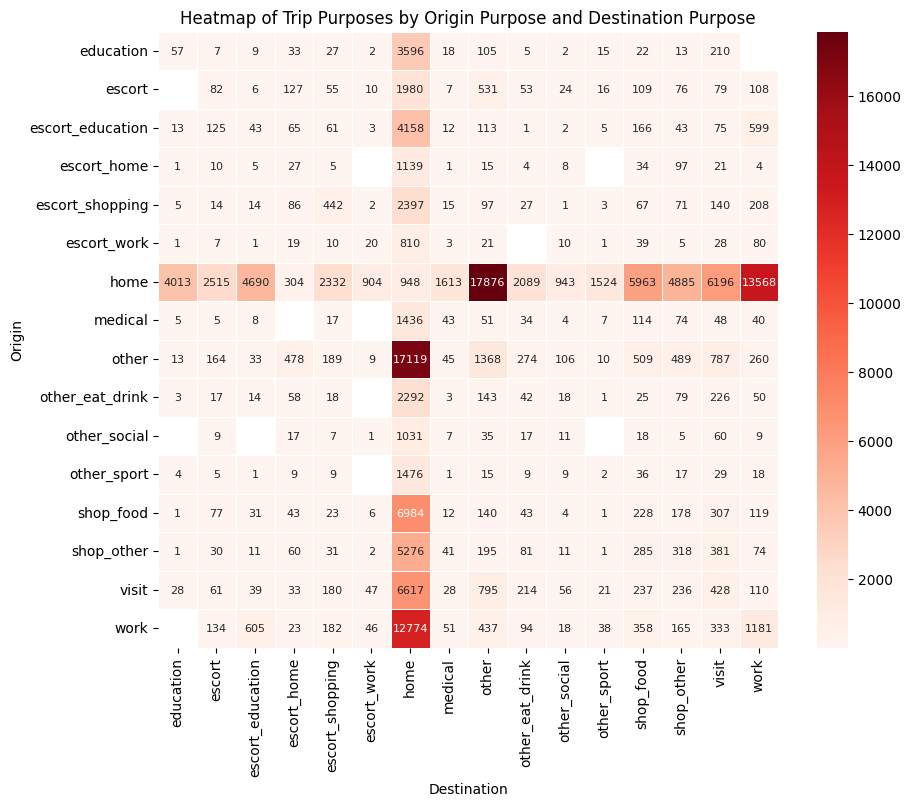

In [5]:
# heatmap showing oact and dact


# create a pivot table
activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count')

# Set the size of the figure
plt.figure(figsize=(10, 8))
# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".0f", cmap='Reds', linewidth=.5, annot_kws={"size": 8})

plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()


#### Heatmap 2: % of Total Trips

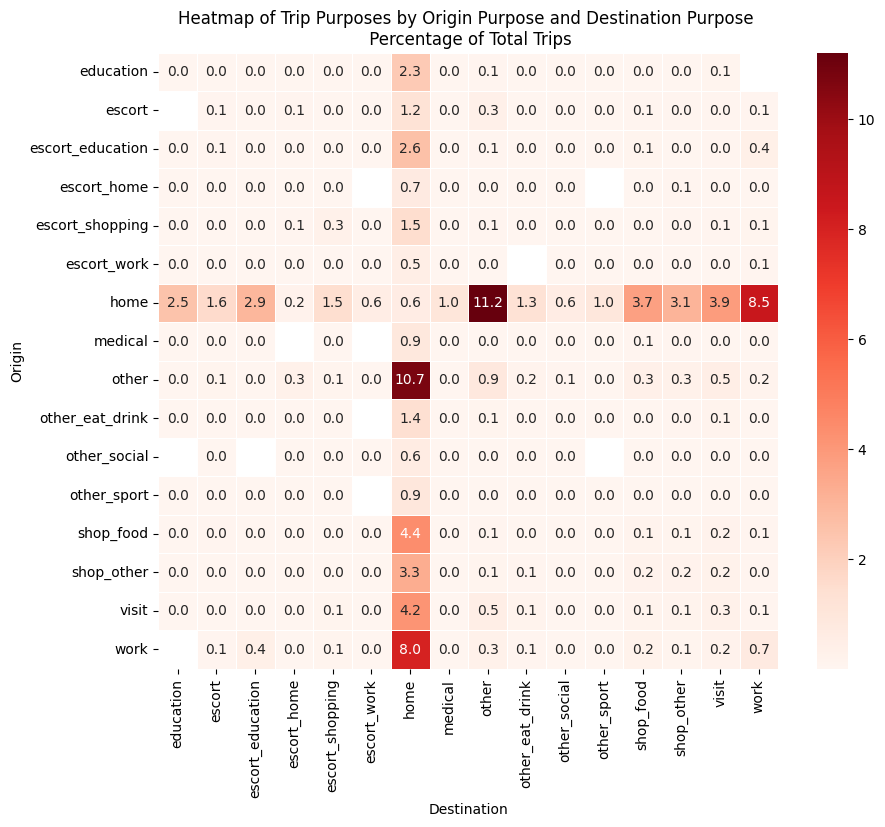

In [6]:
# Set the size of the figure
plt.figure(figsize=(10, 8))

activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count', margins=True, margins_name='Total')
activity_chains_pivot = activity_chains_pivot.div(activity_chains_pivot.loc['Total', 'Total']) * 100
# drop Total row and column
activity_chains_pivot = activity_chains_pivot.drop('Total', axis=0)
activity_chains_pivot = activity_chains_pivot.drop('Total', axis=1)

# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".1f", cmap='Reds', linewidth=.5)

plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose \n Percentage of Total Trips')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()

#### Heatmap 3: Column Normalized (i.e. % of total trips per destination purpose)

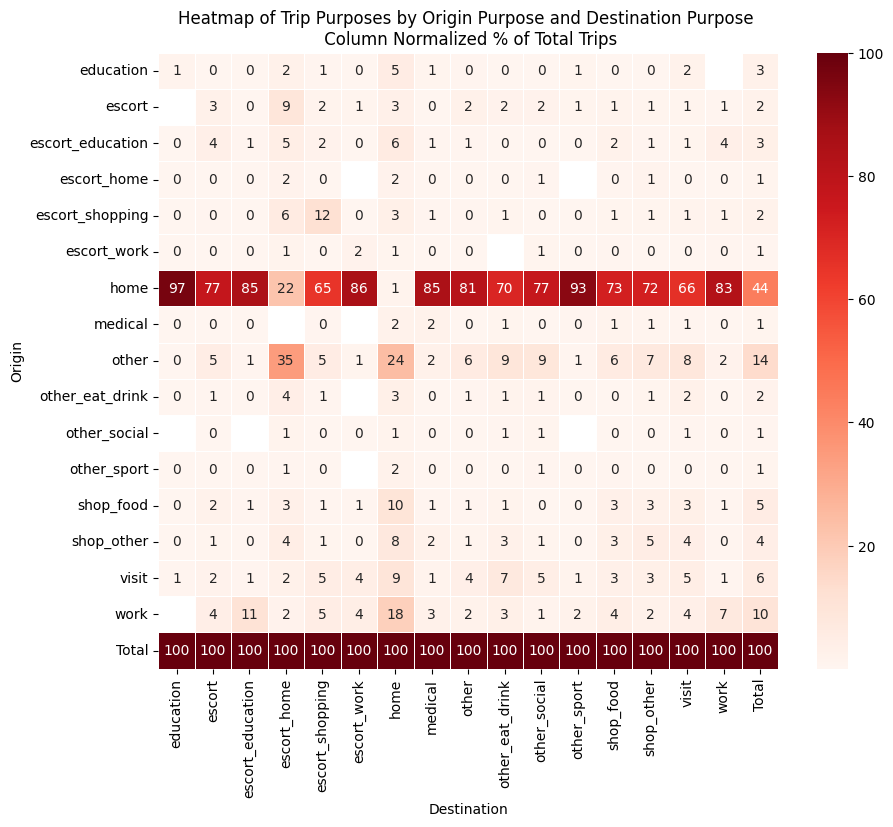

In [7]:
plt.figure(figsize=(10, 8))

activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count', margins=True, margins_name='Total')
activity_chains_pivot = activity_chains_pivot.div(activity_chains_pivot.loc['Total'], axis=1)*100

# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".0f", cmap='Reds', linewidth=.5)


plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose \n Column Normalized % of Total Trips')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()


#### Heatmap 4: Row Normalized (i.e. % of total trips per origin purpose)

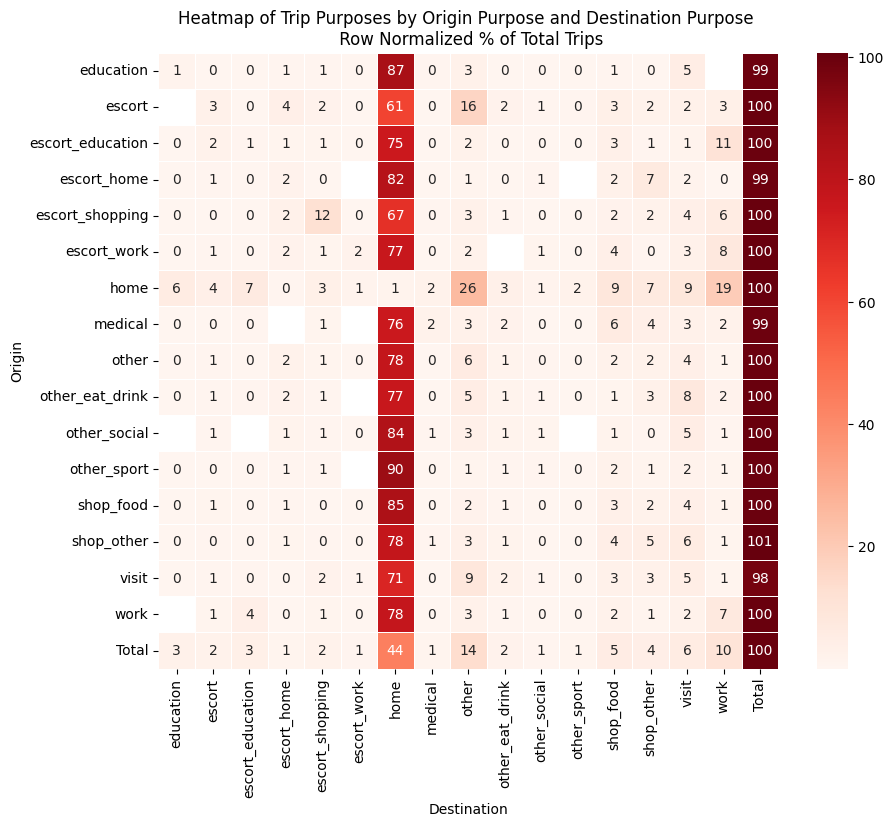

In [8]:
plt.figure(figsize=(10, 8))

# same plot but I want the values to be the percentage of the total trips
activity_chains_pivot = activity_chains.pivot_table(index='oact', columns='dact', values='id', aggfunc='count', margins=True, margins_name='Total')
activity_chains_pivot = activity_chains_pivot.div(activity_chains_pivot.loc['Total'], axis=0)*100

# Create a heatmap from the pivot table
sns.heatmap(activity_chains_pivot, annot=True, fmt =".0f", cmap='Reds', linewidth=.5)

plt.title('Heatmap of Trip Purposes by Origin Purpose and Destination Purpose \n Row Normalized % of Total Trips')
plt.xlabel('Destination')
plt.ylabel('Origin')

plt.show()


## Get travel time matrix for study area

Travel time data between geographical areas (LSOA, OA, custom hexagons etc) is used to determine feasible work / school locations for each individual. The travel times are compared to the travel times of the individual's actual trips from the nts (`tst`/`TripStart` and `tet`/`TripEnd`)

In [12]:
travel_times = pd.read_parquet('../data/external/travel_times/oa/travel_time_matrix_expanded.parquet')
travel_times.head(100)

,from_id,to_id,combination,routes,departure_time,access_time,wait_time,ride_time,transfer_time,egress_time,total_time,n_rides
0,156993,156993,pt_wkday_afternoon,[WALK],12:30:00,0.0,0.0,0.0,0.0,0.0,0.5,0.0
1,156993,156993,pt_wkday_evening,[WALK],18:30:00,0.0,0.0,0.0,0.0,0.0,0.5,0.0
2,156993,156993,pt_wkday_morning,[WALK],07:30:00,0.0,0.0,0.0,0.0,0.0,0.5,0.0
3,156993,156993,pt_wkday_night,[WALK],23:30:00,0.0,0.0,0.0,0.0,0.0,0.5,0.0
4,156993,156993,pt_wkend_evening,[WALK],18:30:00,0.0,0.0,0.0,0.0,0.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,156993,157015,pt_wkday_afternoon,30533|12594|12522,12:30:00,2.9,17.3,32.6,10.2,3.2,66.2,3.0
96,156993,157015,pt_wkday_evening,30533|12657,18:30:00,2.9,12.9,49.0,2.3,5.5,72.6,2.0
97,156993,157015,pt_wkday_morning,30533|12594|12522,07:30:00,2.9,16.7,37.1,10.2,3.2,70.1,3.0
98,156993,157015,pt_wkend_evening,54718|12657,18:30:00,3.8,34.3,43.3,2.1,5.5,89.0,2.0


In [19]:
boundaries = gpd.read_file('../data/external/boundaries/oa_england.geojson')
boundaries.head(10)

,OBJECTID,OA21CD,GlobalID,LSOA21CD,LSOA21NM,MSOA21CD,MSOA21NM,LEP22CD1,LEP22NM1,LAD22CD,LAD22NM,rgn22cd,rgn22nm,ctry22cd,ctry22nm,geometry
0,1,E00000001,bc5eb21b-d42b-4715-a771-2c27575a08f0,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532303.492 181814.110, 532213...."
1,2,E00000003,a1a2b34f-320e-4bb8-acb4-7ca7ca16ef9c,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532213.378 181846.192, 532190...."
2,3,E00000005,9337da1a-fe0f-4210-9c95-ed2d20fd6287,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532180.131 181763.020, 532219...."
3,4,E00000007,b336e11f-af26-48a6-ac67-44f5b8b8840a,E01000001,City of London 001A,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532201.292 181668.180, 532267...."
4,5,E00000010,ca8f9874-cdf5-4c1a-9d39-f74a410dae44,E01000003,City of London 001C,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532127.958 182133.192, 532089...."
5,6,E00000013,b9b93246-bbfb-46af-8011-6b8ed5908956,E01000003,City of London 001C,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532247.654 181897.577, 532248...."
6,7,E00000018,fcb7c232-4165-44da-8ff8-b6cc383b528a,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532440.197 181842.934, 532544...."
7,8,E00000019,715e0851-2375-4d6a-94ac-532ba0833c60,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532619.141 181847.188, 532603...."
8,9,E00000020,4251a2ff-8fbe-4c11-aece-044f23ab9af2,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532515.000 181686.981, 532544...."
9,10,E00000021,48b2df49-45ed-48a4-b7fc-e0e32c1ad088,E01000002,City of London 001B,E02000001,City of London 001,E37000051,The London Economic Action Partnership,E09000001,City of London,E12000007,London,E92000001,England,"MULTIPOLYGON (((532746.813 181786.891, 532671...."


In [20]:
# filter to only include the OA's where "Leeds" is in the MSOA21NM field
boundaries = boundaries[boundaries['MSOA21NM'].str.contains("Leeds", na=False)]

<Axes: >

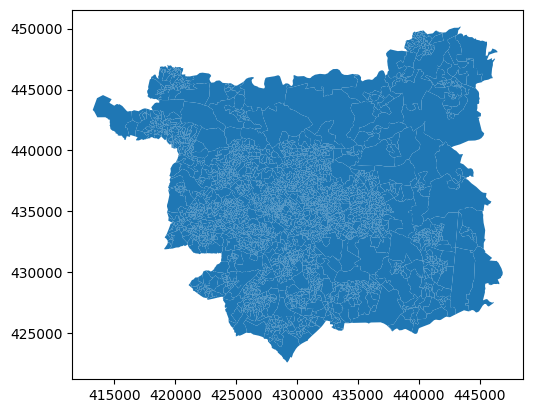

In [21]:
# plot the geometry
boundaries.plot()